<a href="https://colab.research.google.com/github/jllibbi/NLPSpecialization_deeplearningai/blob/main/NLP_Week2_Ass1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Assignment 2: Naive Bayes**

Welcome to week two of this specialization. You will learn about Naive Bayes. Concretely, you will be using Naive Bayes for sentiment analysis on tweets. Given a tweet, you will decide if it has a positive sentiment or a negative one. Specifically you will:

*   Train a naive bayes model on a sentiment analysis task
*   Test using your model
*Compute ratios of positive words to negative words
*Do some error analysis
*Predict on your own tweet

You may already be familiar with Naive Bayes and its justification in terms of conditional probabilities and independence.

*   In this week's lectures and assignments we used the ratio of probabilities between positive and negative sentiments. 
*   This approach gives us simpler formulas for these 2-way classification tasks.

Load the cell below to import some packages. You may want to browse the documentation of unfamiliar libraries and functions.

In [1]:
import pdb
import nltk
import string
import re
import numpy as np
import pandas as pd

from nltk.corpus import stopwords, twitter_samples
from nltk.tokenize import TweetTokenizer
from nltk.stem import PorterStemmer
from os import getcwd

nltk.download('twitter_samples')
nltk.download('stopwords')

[nltk_data] Downloading package twitter_samples to /root/nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
def process_tweet(tweet):
  stemmer = PorterStemmer()
  stopwords_english = stopwords.words('english')
  
  tweet = re.sub(r'\$\w*', '', tweet)
  tweet = re.sub(r'^RT[\s]+', '', tweet)
  tweet = re.sub(r'https?:\/\/.*[\r\n]*', '', tweet)
  tweet = re.sub(r'#', '', tweet)
  tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True,reduce_len=True)
  tweet_tokens = tokenizer.tokenize(tweet)

  tweets_clean = []
  for word in tweet_tokens:
    if (word not in stopwords_english and word not in string.punctuation): 
        stem_word = stemmer.stem(word)  # stemming word
        tweets_clean.append(stem_word)

  return tweets_clean

In [3]:
def build_freqs(tweets, ys):
    """Build frequencies.
    Input:
        tweets: a list of tweets
        ys: an m x 1 array with the sentiment label of each tweet (either 0 or 1)
    Output:
        freqs: a dictionary mapping each (word, sentiment) pair to its frequency
    """
    # Convert np array to list since zip needs an iterable.
    # The squeeze is necessary or the list ends up with one element.
    # Also note that this is just a NOP if ys is already a list.
    yslist = np.squeeze(ys).tolist()

    # Start with an empty dictionary and populate it by looping over all tweets
    # and over all processed words in each tweet.
    freqs = {}
    for y, tweet in zip(yslist, tweets):
        for word in process_tweet(tweet):
            pair = (word, y)
            if pair in freqs:
                freqs[pair] += 1
            else:
                freqs[pair] = 1

    return freqs

In [4]:
def lookup(freqs, word, label):
    '''
    Input:
        freqs: a dictionary with the frequency of each pair (or tuple)
        word: the word to look up
        label: the label corresponding to the word
    Output:
        n: the number of times the word with its corresponding label appears.
    '''
    n = 0  # freqs.get((word, label), 0)

    pair = (word, label)
    if (pair in freqs):
        n = freqs[pair]

    return n

In [5]:
# add folder, tmp2, from our local workspace containing pre-downloaded corpora files to nltk's data path
filePath = f"{getcwd()}/../tmp2/"
nltk.data.path.append(filePath)

In [6]:
# get the sets of positive and negative tweets
all_positive_tweets = twitter_samples.strings('positive_tweets.json')
all_negative_tweets = twitter_samples.strings('negative_tweets.json')

# split the data into two pieces, one for training and one for testing (validation set)
test_pos = all_positive_tweets[4000:]
train_pos = all_positive_tweets[:4000]
test_neg = all_negative_tweets[4000:]
train_neg = all_negative_tweets[:4000]

train_x = train_pos + train_neg
test_x = test_pos + test_neg

# avoid assumptions about the length of all_positive_tweets
train_y = np.append(np.ones(len(train_pos)), np.zeros(len(train_neg)))
test_y = np.append(np.ones(len(test_pos)), np.zeros(len(test_neg)))

tweets = all_positive_tweets + all_negative_tweets

##**Part 1: Process the Data**
For any machine learning project, once you've gathered the data, the first step is to process it to make useful inputs to your model.

*   **Remove noise**: You will first want to remove noise from your data -- that is, remove words that don't tell you much about the content. These include all common words like 'I, you, are, is, etc...' that would not give us enough information on the sentiment.
*   We'll also remove stock market tickers, retweet symbols, hyperlinks, and hashtags because they can not tell you a lot of information on the sentiment.
*You also want to remove all the punctuation from a tweet. The reason for doing this is because we want to treat words with or without the punctuation as the same word, instead of treating "happy", "happy?", "happy!", "happy," and "happy." as different words.
*Finally you want to use stemming to only keep track of one variation of each word. In other words, we'll treat "motivation", "motivated", and "motivate" similarly by grouping them within the same stem of "motiv-".

We have given you the function `process_tweet()` that does this for you.

In [7]:
custom_tweet = "RT @Twitter @chapagain Hello There! Have a great day. :) #good #morning http://chapagain.com.np"

# print cleaned tweet
print(process_tweet(custom_tweet))

['hello', 'great', 'day', ':)', 'good', 'morn']


###**Part 1.1 Implementing your helper functions**
To help train your naive bayes model, you will need to build a dictionary where the keys are a (word, label) tuple and the values are the corresponding frequency. Note that the labels we'll use here are 1 for positive and 0 for negative.

You will also implement a `lookup()` helper function that takes in the `freqs` dictionary, a word, and a label (1 or 0) and returns the number of times that word and label tuple appears in the collection of tweets.

For example: given a list of tweets `["i am rather excited", "you are rather happy"]` and the label 1, the function will return a dictionary that contains the following key-value pairs:


{ ("rather", 1): 2 ("happi", 1) : 1 ("excit", 1) : 1 }



*   Notice how for each word in the given string, the same label 1 is assigned to each word.
*   Notice how the words "i" and "am" are not saved, since it was removed by process_tweet because it is a stopword.
*Notice how the word "rather" appears twice in the list of tweets, and so its count value is 2.

**Instructions**
Create a function `count_tweets()` that takes a list of tweets as input, cleans all of them, and returns a dictionary.

*   The key in the dictionary is a tuple containing the stemmed word and its class label, e.g. ("happi",1).
*   The value the number of times this word appears in the given collection of tweets (an integer).

**Hints** 
*   Please use the `process_tweet` function that was imported above, and then store the words in their respective dictionaries and sets.
*   You may find it useful to use the `zip` function to match each element in `tweets` with each element in `ys`.
*Remember to check if the key in the dictionary exists before adding that key to the dictionary, or incrementing its value.
*Assume that the `result` dictionary that is input will contain clean key-value pairs (you can assume that the values will be integers that can be incremented). It is good practice to check the datatype before incrementing the value, but it's not required here.

In [8]:
# UNQ_C1 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
def count_tweets(result, tweets, ys):
    '''
    Input:
        result: a dictionary that will be used to map each pair to its frequency
        tweets: a list of tweets
        ys: a list corresponding to the sentiment of each tweet (either 0 or 1)
    Output:
        result: a dictionary mapping each pair to its frequency
    '''

    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    for y, tweet in zip(ys, tweets):
        for word in process_tweet(tweet):
            # define the key, which is the word and label tuple
            pair = (word, y)

            # if the key exists in the dictionary, increment the count
            if pair in result:
                result[pair] += 1

            # else, if the key is new, add it to the dictionary and set the count to 1
            else:
                result[pair] = 1
    ### END CODE HERE ###

    return result

In [9]:
# Testing your function


result = {}
tweets = ['i am happy', 'i am tricked', 'i am sad', 'i am tired', 'i am tired']
ys = [1, 0, 0, 0, 0]
count_tweets(result, tweets, ys)

{('happi', 1): 1, ('sad', 0): 1, ('tire', 0): 2, ('trick', 0): 1}

**Expected Output**: {('happi', 1): 1, ('trick', 0): 1, ('sad', 0): 1, ('tire', 0): 2}

##**Part 2: Train your model using Naive Bayes**
Naive bayes is an algorithm that could be used for sentiment analysis. It takes a short time to train and also has a short prediction time.

**So how do you train a Naive Bayes classifier?**


*   The first part of training a naive bayes classifier is to identify the number of classes that you have.
*   You will create a probability for each class. *P(D<sub>pos</sub>)* is the probability that the document is positive. *P(D<sub>neg</sub>)* is the probability that the document is negative. Use the formulas as follows and store the values in a dictionary:

(1) *P(D<sub>pos</sub>)* = *D<sub>pos</sub>* / *D*

(2) *P(D<sub>neg</sub>)* = *D<sub>neg</sub>* / *D*

Where *D* is the total number of documents, or tweets in this case, *D<sub>pos</sub>* is the total number of positive tweets and *D<sub>neg</sub>* is the total number of negative tweets.

**Prior and Logprior**
The prior probability represents the underlying probability in the target population that a tweet is positive versus negative. In other words, if we had no specific information and blindly picked a tweet out of the population set, what is the probability that it will be positive versus that it will be negative? That is the "prior".

The prior is the ratio of the probabilities *P(D<sub>pos</sub>)* / *P(D<sub>neg</sub>)*. We can take the log of the prior to rescale it, and we'll call this the logprior

logprior = *log*(*P(D<sub>pos</sub>)* / *P(D<sub>neg</sub>)*) = *log*(*D<sub>pos</sub>* / *D<sub>neg</sub>*)

Note that *log(A/B)* is the same as *log(A)-log(B)*. So the logprior can also be calculated as the difference between two logs:

(3) logprior = *log(P(D<sub>pos</sub>))* - *log(P(D<sub>neg</sub>))* = *log(D<sub>pos</sub>)* - *log(D<sub>neg</sub>)*

**Positive and Negative Probability of a Word**
To compute the positive probability and the negative probability for a specific word in the vocabulary, we'll use the following inputs:


*   ***freq<sub>pos</sub>*** and ***freq<sub>neg</sub>*** are the frequencies of that specific word in the positive or negative class. In other words, the positive frequency of a word is the number of times the word is counted with the label of 1.
*   ***N<sub>pos</sub>*** and ***N<sub>neg</sub>*** are the total number of positive and negative words for all documents (for all tweets), respectively.
* ***V*** is the number of unique words in the entire set of documents, for all classes, whether positive or negative.

We'll use these to compute the positive and negative probability for a specific word using this formula:

(4) *P(W<sub>pos</sub>)* = *freq<sub>pos</sub>+1* / *N<sub>pos</sub>*+*V*

(5) *P(W<sub>neg</sub>)* = *freq<sub>neg</sub>+1* / *N<sub>neg</sub>*+*V*

Notice that we add the "+1" in the numerator for additive smoothing. This [wiki article](https://en.wikipedia.org/wiki/Additive_smoothing) explains more about additive smoothing.

**Log likelihood**
To compute the loglikelihood of that very same word, we can implement the following equations:

(6) **loglikelihood** = log(*P(W<sub>pos</sub>)*/*P(W<sub>neg</sub>)*)

Create `freqs` dictionary


*   Given your `count_tweets()` function, you can compute a dictionary called `freqs` that contains all the frequencies.
*   In this `freqs` dictionary, the key is the tuple (word, label)
* The value is the number of times it has appeared.

We will use this dictionary in several parts of this assignment.

In [10]:
# Build the freqs dictionary for later uses

freqs = count_tweets({}, train_x, train_y)

**Instructions**
Given a freqs dictionary, `train_x` (a list of tweets) and a `train_y` (a list of labels for each tweet), implement a naive bayes classifier.

**Calculate *V***

*   You can then compute the number of unique words that appear in the `freqs` dictionary to get your ***V*** (you can use the `set` function).

**Calculate *freq<sub>pos</sub>* and *freq<sub>neg</sub>*** 
* Using your `freqs` dictionary, you can compute the positive and negative frequency of each word ***freq<sub>pos</sub>*** and ***freq<sub>neg</sub>***.

**Calculate *N<sub>pos</sub>* and *N<sub>neg</sub>***
* Using `freqs` dictionary, you can also compute the total number of positive words and total number of negative words ***N<sub>pos</sub>*** and ***N<sub>neg</sub>***.

**Calculate , *D*, *D<sub>pos</sub>*, *D<sub>neg</sub>***
* Using the `train_y` input list of labels, calculate the number of documents (tweets) ***D***, as well as the number of positive documents (tweets) ***D<sub>pos</sub>*** and number of negative documents (tweets) ***D<sub>neg</sub>***.
* Calculate the probability that a document (tweet) is positive ***P(D<sub>pos</sub>)***, and the probability that a document (tweet) is negative ***P(D<sub>neg</sub>)***

**Calculate the logprior**
* the logprior is ***log(D<sub>pos</sub>) - log(D<sub>neg</sub>)***

**Calculate log likelihood**
* Finally, you can iterate over each word in the vocabulary, use your `lookup` function to get the positive frequencies, ***freq<sub>pos</sub>***, and the negative frequencies, ***freq<sub>neg</sub>***, for that specific word.
* Compute the positive probability of each word ***P(W<sub>pos</sub>)***, negative probability of each word ***P(W<sub>neg</sub>)*** using equations 4 & 5.

(4) ***P(W<sub>pos</sub>)*** = ***freq<sub>pos</sub>***+ 1 / ***N<sub>pos</sub>*** + ***V***


(5) ***P(W<sub>neg</sub>)*** = ***freq<sub>neg</sub>***+ 1 / ***N<sub>neg</sub>*** + ***V***

**Note**: We'll use a dictionary to store the log likelihoods for each word. The key is the word, the value is the log likelihood of that word).



*   You can then compute the loglikelihood: ***log(P(W<sub>pos</sub>) / P(W<sub>neg</sub>))***



In [11]:
# UNQ_C2 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
def train_naive_bayes(freqs, train_x, train_y):
    '''
    Input:
        freqs: dictionary from (word, label) to how often the word appears
        train_x: a list of tweets
        train_y: a list of labels correponding to the tweets (0,1)
    Output:
        logprior: the log prior. (equation 3 above)
        loglikelihood: the log likelihood of you Naive bayes equation. (equation 6 above)
    '''
    loglikelihood = {}
    logprior = 0

    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###

    # calculate V, the number of unique words in the vocabulary
    vocab = set([pair[0] for pair in freqs.keys()])
    V = len(vocab)

    # calculate N_pos and N_neg
    N_pos = N_neg = 0
    for pair in freqs.keys():
        # if the label is positive (greater than zero)
        if pair[1] > 0:

            # Increment the number of positive words by the count for this (word, label) pair
            N_pos += freqs[pair]

        # else, the label is negative
        else:

            # increment the number of negative words by the count for this (word,label) pair
            N_neg += freqs[pair]

    # Calculate D, the number of documents
    D = len(train_y)

    # Calculate D_pos, the number of positive documents (*hint: use sum(<np_array>))
    D_pos = train_y.sum()

    # Calculate D_neg, the number of negative documents (*hint: compute using D and D_pos)
    D_neg = D-D_pos

    # Calculate logprior
    logprior = np.log(D_pos)-np.log(D_neg)

    # For each word in the vocabulary...
    for word in vocab:
        # get the positive and negative frequency of the word
        freq_pos = lookup(freqs,word,1)
        freq_neg = lookup(freqs,word,0)

        # calculate the probability that each word is positive, and negative
        p_w_pos = (freq_pos+1)/(N_pos+V)
        p_w_neg = (freq_neg+1)/(N_neg+V)

        # calculate the log likelihood of the word
        loglikelihood[word] = np.log(p_w_pos/p_w_neg)

    ### END CODE HERE ###

    return logprior, loglikelihood

In [12]:
# UNQ_C3 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# You do not have to input any code in this cell, but it is relevant to grading, so please do not change anything
logprior, loglikelihood = train_naive_bayes(freqs, train_x, train_y)
print(logprior)
print(len(loglikelihood))

0.0
9089


**Expected Output:**

0.0

9089

##**Part 3: Test your naive bayes**
Now that we have the `logprior` and `loglikelihood`, we can test the naive bayes function by making predicting on some tweets!

**Implement `naive_bayes_predict`**

**Instructions:** Implement the `naive_bayes_predict` function to make predictions on tweets.


*   The function takes in the `tweet`, `logprior`, `loglikelihood`.
*   It returns the probability that the tweet belongs to the positive or negative class.
* For each tweet, sum up loglikelihoods of each word in the tweet.
* Also add the logprior to this sum to get the predicted sentiment of that tweet.

***p* = *logprior + zigma(loglikelihood)***

**Note**
Note we calculate the prior from the training data, and that the training data is evenly split between positive and negative labels (4000 positive and 4000 negative tweets). This means that the ratio of positive to negative 1, and the logprior is 0.

The value of 0.0 means that when we add the logprior to the log likelihood, we're just adding zero to the log likelihood. However, please remember to include the logprior, because whenever the data is not perfectly balanced, the logprior will be a non-zero value.

In [13]:
# UNQ_C4 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
def naive_bayes_predict(tweet, logprior, loglikelihood):
    '''
    Input:
        tweet: a string
        logprior: a number
        loglikelihood: a dictionary of words mapping to numbers
    Output:
        p: the sum of all the logliklihoods of each word in the tweet (if found in the dictionary) + logprior (a number)

    '''
    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    # process the tweet to get a list of words
    word_l = process_tweet(tweet)

    # initialize probability to zero
    p = 0

    # add the logprior
    p += logprior

    for word in word_l:

        # check if the word exists in the loglikelihood dictionary
        if word in loglikelihood:
            # add the log likelihood of that word to the probability
            p += loglikelihood[word]

    ### END CODE HERE ###

    return p

In [14]:
# UNQ_C5 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# You do not have to input any code in this cell, but it is relevant to grading, so please do not change anything

# Experiment with your own tweet.
my_tweet = 'She smiled.'
p = naive_bayes_predict(my_tweet, logprior, loglikelihood)
print('The expected output is', p)

The expected output is 1.5740278623499175


**Expected Output:**

*   The expected output is around 1.57
*   The sentiment is positive.

###**Implement test_naive_bayes**
**Instructions:**

* Implement `test_naive_bayes` to check the accuracy of your predictions.
* The function takes in your `test_x`, `test_y`, log_prior, and loglikelihood
* It returns the accuracy of your model.
* First, use `naive_bayes_predict` function to make predictions for each tweet in text_x.

In [15]:
# UNQ_C6 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
def test_naive_bayes(test_x, test_y, logprior, loglikelihood):
    """
    Input:
        test_x: A list of tweets
        test_y: the corresponding labels for the list of tweets
        logprior: the logprior
        loglikelihood: a dictionary with the loglikelihoods for each word
    Output:
        accuracy: (# of tweets classified correctly)/(total # of tweets)
    """
    accuracy = 0  # return this properly

    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    y_hats = []
    for tweet in test_x:
        # if the prediction is > 0
        if naive_bayes_predict(tweet, logprior, loglikelihood) > 0:
            # the predicted class is 1
            y_hat_i = 1
        else:
            # otherwise the predicted class is 0
            y_hat_i = 0

        # append the predicted class to the list y_hats
        y_hats.append(y_hat_i)

    # error is the average of the absolute values of the differences between y_hats and test_y
    error = np.mean(np.absolute(y_hats-test_y))

    # Accuracy is 1 minus the error
    accuracy = 1 - error

    ### END CODE HERE ###

    return accuracy

In [16]:
print("Naive Bayes accuracy = %0.4f" %
      (test_naive_bayes(test_x, test_y, logprior, loglikelihood)))

Naive Bayes accuracy = 0.9940


**Expected Accuracy:**

0.9940

In [17]:
# UNQ_C7 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# You do not have to input any code in this cell, but it is relevant to grading, so please do not change anything

# Run this cell to test your function
for tweet in ['I am happy', 'I am bad', 'this movie should have been great.', 'great', 'great great', 'great great great', 'great great great great']:
    # print( '%s -> %f' % (tweet, naive_bayes_predict(tweet, logprior, loglikelihood)))
    p = naive_bayes_predict(tweet, logprior, loglikelihood)
#     print(f'{tweet} -> {p:.2f} ({p_category})')
    print(f'{tweet} -> {p:.2f}')

I am happy -> 2.15
I am bad -> -1.29
this movie should have been great. -> 2.14
great -> 2.14
great great -> 4.28
great great great -> 6.41
great great great great -> 8.55


**Expected Output:**

* I am happy -> 2.15
* I am bad -> -1.29
* this movie should have been great. -> 2.14
* great -> 2.14
* great great -> 4.28
* great great great -> 6.41
* great great great great -> 8.55

In [18]:
# Feel free to check the sentiment of your own tweet below
my_tweet = 'you are bad :('
naive_bayes_predict(my_tweet, logprior, loglikelihood) 

-8.801622640492191

##**Part 4: Filter words by Ratio of positive to negative counts**
* Some words have more positive counts than others, and can be considered "more positive". Likewise, some words can be considered more negative than others.
* One way for us to define the level of positiveness or negativeness, without calculating the log likelihood, is to compare the positive to negative frequency of the word.
    - Note that we can also use the log likelihood calculations to compare relative positivity or negativity of words.
* We can calculate the ratio of positive to negative frequencies of a word.
* Once we're able to calculate these ratios, we can also filter a subset of words that have a minimum ratio of positivity / negativity or higher.
* Similarly, we can also filter a subset of words that have a maximum ratio of positivity / negativity or lower (words that are at least as negative, or even more negative than a given threshold).

**Implement `get_ratio()`**
* Given the `freqs` dictionary of words and a particular word, use `lookup(freqs,word,1)` to get the positive count of the word.
* Similarly, use the `lookup()` function to get the negative count of that word.
* Calculate the ratio of positive divided by negative counts

*ratio* = pos_words + 1 / neg_words + 1

Where pos_words and neg_words correspond to the frequency of the words in their respective classes.

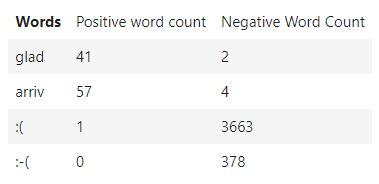

In [19]:
# UNQ_C8 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
def get_ratio(freqs, word):
    '''
    Input:
        freqs: dictionary containing the words
        word: string to lookup

    Output: a dictionary with keys 'positive', 'negative', and 'ratio'.
        Example: {'positive': 10, 'negative': 20, 'ratio': 0.5}
    '''
    pos_neg_ratio = {'positive': 0, 'negative': 0, 'ratio': 0.0}
    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    # use lookup() to find positive counts for the word (denoted by the integer 1)
    pos_neg_ratio['positive'] = lookup(freqs,word,1)

    # use lookup() to find negative counts for the word (denoted by integer 0)
    pos_neg_ratio['negative'] = lookup(freqs,word,0)

    # calculate the ratio of positive to negative counts for the word
    pos_neg_ratio['ratio'] = (pos_neg_ratio['positive'] + 1) / (pos_neg_ratio['negative'] + 1)
    ### END CODE HERE ###
    return pos_neg_ratio

In [20]:
get_ratio(freqs, 'happi')

{'negative': 18, 'positive': 161, 'ratio': 8.526315789473685}

**Implement `get_words_by_threshold(freqs,label,threshold)`**
* If we set the label to 1, then we'll look for all words whose threshold of positive/negative is at least as high as that threshold, or higher.
* If we set the label to 0, then we'll look for all words whose threshold of positive/negative is at most as low as the given threshold, or lower.
* Use the `get_ratio()` function to get a dictionary containing the positive count, negative count, and the ratio of positive to negative counts.
* Append a dictionary to a list, where the key is the word, and the dictionary is the dictionary `pos_neg_ratio` that is returned by the `get_ratio()` function. An example key-value pair would have this structure:

{'happi':
  
  {'positive': 10, 'negative': 20, 'ratio': 0.5}

}

In [21]:
# UNQ_C9 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
def get_words_by_threshold(freqs, label, threshold):
    '''
    Input:
        freqs: dictionary of words
        label: 1 for positive, 0 for negative
        threshold: ratio that will be used as the cutoff for including a word in the returned dictionary
    Output:
        word_set: dictionary containing the word and information on its positive count, negative count, and ratio of positive to negative counts.
        example of a key value pair:
        {'happi':
            {'positive': 10, 'negative': 20, 'ratio': 0.5}
        }
    '''
    word_list = {}

    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    for key in freqs.keys():
        word, _ = key

        # get the positive/negative ratio for a word
        pos_neg_ratio = get_ratio(freqs, word)

        # if the label is 1 and the ratio is greater than or equal to the threshold...
        if label == 1 and pos_neg_ratio['ratio'] >= threshold:

            # Add the pos_neg_ratio to the dictionary
            word_list[word] = pos_neg_ratio #dictionaryname[key]=value

        # If the label is 0 and the pos_neg_ratio is less than or equal to the threshold...
        elif label == 0 and pos_neg_ratio['ratio'] <= threshold:

            # Add the pos_neg_ratio to the dictionary
            word_list[word] = pos_neg_ratio

        # otherwise, do not include this word in the list (do nothing)

    ### END CODE HERE ###
    return word_list

In [22]:
# Test your function: find negative words at or below a threshold
get_words_by_threshold(freqs, label=0, threshold=0.05)

{'26': {'negative': 20, 'positive': 0, 'ratio': 0.047619047619047616},
 ':(': {'negative': 3663, 'positive': 1, 'ratio': 0.0005458515283842794},
 ':-(': {'negative': 378, 'positive': 0, 'ratio': 0.002638522427440633},
 '>:(': {'negative': 43, 'positive': 0, 'ratio': 0.022727272727272728},
 'beli̇ev': {'negative': 35, 'positive': 0, 'ratio': 0.027777777777777776},
 'justi̇n': {'negative': 35, 'positive': 0, 'ratio': 0.027777777777777776},
 'lost': {'negative': 19, 'positive': 0, 'ratio': 0.05},
 'wi̇ll': {'negative': 35, 'positive': 0, 'ratio': 0.027777777777777776},
 'zayniscomingbackonjuli': {'negative': 19, 'positive': 0, 'ratio': 0.05},
 '♛': {'negative': 210, 'positive': 0, 'ratio': 0.004739336492890996},
 '》': {'negative': 210, 'positive': 0, 'ratio': 0.004739336492890996},
 'ｍｅ': {'negative': 35, 'positive': 0, 'ratio': 0.027777777777777776},
 'ｓｅｅ': {'negative': 35, 'positive': 0, 'ratio': 0.027777777777777776}}

In [23]:
# Test your function; find positive words at or above a threshold
get_words_by_threshold(freqs, label=1, threshold=10)

{':)': {'negative': 2, 'positive': 2847, 'ratio': 949.3333333333334},
 ':-)': {'negative': 0, 'positive': 543, 'ratio': 544.0},
 ':D': {'negative': 0, 'positive': 498, 'ratio': 499.0},
 ':p': {'negative': 0, 'positive': 103, 'ratio': 104.0},
 ';)': {'negative': 0, 'positive': 22, 'ratio': 23.0},
 'arriv': {'negative': 4, 'positive': 57, 'ratio': 11.6},
 'bam': {'negative': 0, 'positive': 44, 'ratio': 45.0},
 'blog': {'negative': 0, 'positive': 27, 'ratio': 28.0},
 'commun': {'negative': 1, 'positive': 27, 'ratio': 14.0},
 'fav': {'negative': 0, 'positive': 11, 'ratio': 12.0},
 'fback': {'negative': 0, 'positive': 26, 'ratio': 27.0},
 'flipkartfashionfriday': {'negative': 0, 'positive': 16, 'ratio': 17.0},
 'followfriday': {'negative': 0, 'positive': 23, 'ratio': 24.0},
 'glad': {'negative': 2, 'positive': 41, 'ratio': 14.0},
 "here'": {'negative': 0, 'positive': 20, 'ratio': 21.0},
 'influenc': {'negative': 0, 'positive': 16, 'ratio': 17.0},
 'pleasur': {'negative': 0, 'positive': 10, 

Notice the difference between the positive and negative ratios. Emojis like :( and words like 'me' tend to have a negative connotation. Other words like 'glad', 'community', and 'arrives' tend to be found in the positive tweets.

##**Part 5: Error Analysis**
In this part you will see some tweets that your model missclassified. Why do you think the misclassifications happened? Were there any assumptions made by the naive bayes model?

In [24]:
# Some error analysis done for you
print('Truth Predicted Tweet')
for x, y in zip(test_x, test_y):
    y_hat = naive_bayes_predict(x, logprior, loglikelihood)
    if y != (np.sign(y_hat) > 0):
        print('%d\t%0.2f\t%s' % (y, np.sign(y_hat) > 0, ' '.join(
            process_tweet(x)).encode('ascii', 'ignore')))

Truth Predicted Tweet
1	0.00	b''
1	0.00	b'truli later move know queen bee upward bound movingonup'
1	0.00	b'new report talk burn calori cold work harder warm feel better weather :p'
1	0.00	b'harri niall 94 harri born ik stupid wanna chang :D'
1	0.00	b''
1	0.00	b''
1	0.00	b'park get sunlight'
1	0.00	b'uff itna miss karhi thi ap :p'
0	1.00	b'hello info possibl interest jonatha close join beti :( great'
0	1.00	b'u prob fun david'
0	1.00	b'pat jay'
0	1.00	b'whatev stil l young >:-('


##**Part 6: Predict with your own tweet**
In this part you can predict the sentiment of your own tweet.

In [25]:
# Test with your own tweet - feel free to modify `my_tweet`
my_tweet = 'I am happy because I am learning :)'

p = naive_bayes_predict(my_tweet, logprior, loglikelihood)
print(p)

9.574768961173339


Congratulations on completing this assignment. See you next week!